<a href="https://colab.research.google.com/github/koreahong/regression_analysis_study/blob/main/%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D_5%EA%B0%9C_%EC%A1%B0%EA%B1%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import *

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.datasets import load_boston

from patsy import dmatrix

import copy

1. 등분산성
  - 설명변수와 잔차간에 분산이 일정해야함.

2. 잔차의 정규성
  - Q-Q plot
  - shapiro 검정
      - 귀무가설: 정규분포가 아님

3. 선형성, 등분산성
  - 잔차와 독립 변수의 관계를 그린 그래프 확인. 일정해야함

4. 잔차의 자기상관성 확인(독립성)
  - 더빈-왓슨 검정 -> 2에 가까워야함
  - 변수의 차분 필요

In [88]:
## 최종 적합 코드
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
# or 데이터프레임.values

dfX0['MEDV'] = boston.target

# 잔차정규성 확인

In [6]:
model1 = sm.OLS(np.log1p(dfy), dfX)
result1 = model1.fit()
resid = model1.fit().resid

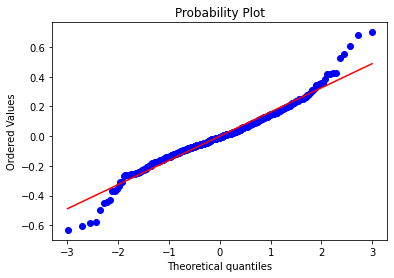

In [11]:
plt.figure()
probplot(resid, plot=plt)
plt.show()

In [18]:
stats.shapiro(resid)

(0.9659236073493958, 1.9045744981127655e-09)

# 모형의 선형성 파악

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


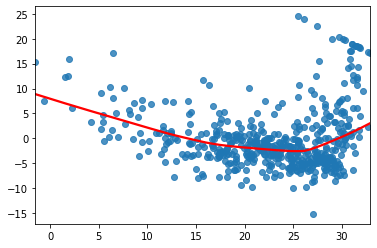

In [60]:
model = ols('MEDV~LSTAT', data=dfX0).fit()
resid = model.resid
fitted = model.predict(dfX0)
sns.regplot(fitted, resid, lowess=True, line_kws={'color': 'red'})

비선형관계 포착  
독립변수 다항으로 변환 or 제곱근 씌우기 and 종속변수 로그변환 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


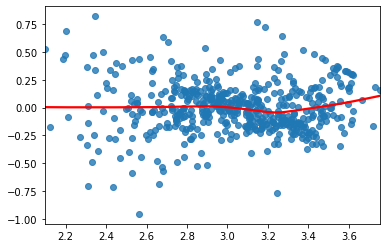

In [89]:
model = ols('np.log(MEDV)~np.sqrt(LSTAT)', data=dfX0).fit()
resid = model.resid
fitted = model.predict(dfX0)
sns.regplot(fitted, resid, lowess=True, line_kws={'color': 'red'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


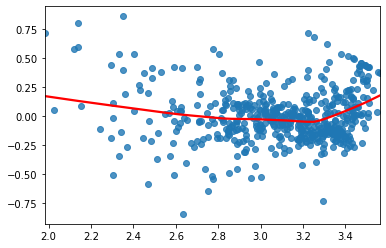

In [112]:
model = ols('np.log1p(MEDV)~scale(I(LSTAT**2))', data=dfX0).fit()
resid = model.resid
fitted = model.predict(dfX0)
sns.regplot(fitted, resid, lowess=True, line_kws={'color': 'red'})

# 모형의 등분산성

In [85]:
sr = stats.zscore(resid)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


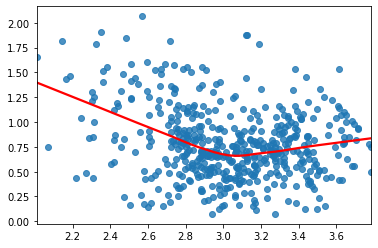

In [86]:
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

# 잔차 독립성

In [91]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1074.
Date:                Thu, 09 Sep 2021   Prob (F-statistic):          5.06e-127
Time:                        10:16:07   Log-Likelihood:                 24.005
No. Observations:                 506   AIC:                            -44.01
Df Residuals:                     504   BIC:                            -35.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.2021      0.037    113.

# 다중공선성 확인  
다중공선성 확인
5이상이면 제거대상

In [94]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.076332,CHAS
1,1.079982,Intercept
2,1.386912,scale(B)
3,1.903334,scale(np.log(PTRATIO))
4,2.066656,scale(RM)
5,3.328917,scale(AGE)
6,3.382630,scale(np.sqrt(LSTAT))
7,4.099287,scale(INDUS)
8,4.834970,scale(NOX)
9,5.368257,scale(np.log(DIS))


In [30]:
VIF1 = vif.iloc[:-1, 1].values

In [31]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX[VIF1].values, i) for i in range(dfX[VIF1].shape[1])]
vif["features"] = dfX[VIF1].columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.049792,CHAS
1,1.078010,Intercept
2,1.343364,scale(B)
3,1.534189,scale(np.log(PTRATIO))
4,1.808154,scale(CRIM)
5,1.874766,scale(RM)
6,2.737322,scale(RAD)
7,2.796851,scale(np.sqrt(LSTAT))
8,3.532133,scale(np.log(DIS))
9,4.257284,scale(NOX)
